TransformerとTokenizerは.pyで保存済みなため学習ループの実装する

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from GPT2 import Transformer, ModelConfig
from Tokenizer import Tokenizer

# データセットの作成
class TextDataset(Dataset):
    def __init__(self, text, tokenizer, block_size):
        self.tokenizer = tokenizer
        self.block_size = block_size
        self.tokens = self.tokenizer.encode(text, eot=True)

    def __len__(self):
        return len(self.tokens) - self.block_size

    def __getitem__(self, idx):
        return torch.tensor(self.tokens[idx:idx+self.block_size]), torch.tensor(self.tokens[idx+1:idx+self.block_size+1])

# データセットの読み込み
# 相対パスを指定してテキストファイルを読み込む
file_path1 = "../data/ptb.train.txt"
file_path2 = "../data/ptb.valid.txt"
file_path3 = "../data/ptb.test.txt"

# ファイルを開いて内容を読み込む
with open(file_path1, "r", encoding="utf-8") as file:
    ptb_train_text = file.read()

with open(file_path2, "r", encoding="utf-8") as file:
    ptb_valid_text = file.read()

with open(file_path3, "r", encoding="utf-8") as file:
    ptb_test_text = file.read()



# Tokenizerの初期化
unique_chars_in_train_text = sorted(list(set(ptb_train_text)))
tokenizer = Tokenizer(unique_chars_in_train_text)

# モデルの初期化
device = 'cuda' if torch.cuda.is_available() else 'cpu'
block_size = 128
vocab_size = len(tokenizer.str_to_idx)
config = ModelConfig(
    block_size=128,    # シーケンス長
    vocab_size= vocab_size,  # ボキャブラリサイズ（例: GPTのボキャブラリ）
    n_layer=12,        # 層数
    n_embd=768,        # 埋め込み次元
    n_head=32,         # アテンションヘッド
    dropout=0.1        # ドロップアウト率
)

transformer = Transformer(config).to(device)

# データセットの作成
train_dataset = TextDataset(ptb_train_text, tokenizer, block_size)
valid_dataset = TextDataset(ptb_valid_text, tokenizer, block_size)
test_dataset = TextDataset(ptb_test_text, tokenizer, block_size)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# 学習ループの実装
def train(model, dataloader, optimizer, epochs, device):
    model.train()  # モデルを訓練モードに設定
    losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (input_ids, target_ids) in enumerate(dataloader):
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)

            # モデルの順伝播
            logits, loss, attention = model(input_ids, targets=target_ids)

            # 損失の計算と逆伝播
            optimizer.zero_grad()  # 勾配の初期化
            loss.backward()  # 逆伝播
            optimizer.step()  # パラメータ更新

            running_loss += loss.item()
            losses.append(loss.item())

            if i % 100 == 99:  # 100ステップごとに進捗を表示
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], Loss: {running_loss / 100:.4f}")
                running_loss = 0.0

    print("学習完了")
    return losses

トランスフォーマーの総パラメータ数: 85.63M


In [4]:
optimizer = torch.optim.AdamW(transformer.parameters(), lr=3e-4)
train(transformer, train_loader, optimizer, epochs=1, device=device)

# モデルの評価
def evaluate(model, dataloader, device):
    model.eval()  # モデルを評価モードに設定
    total_loss = 0.0
    with torch.no_grad():
        for input_ids, target_ids in dataloader:
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)

            # モデルの順伝播
            logits, loss = model(input_ids, targets=target_ids)
            total_loss += loss.item()

    return total_loss / len(dataloader)

# モデルの評価
val_loss = evaluate(transformer, valid_loader, device)
print(f"Validation Loss: {val_loss:.4f}")

Epoch [1/1], Step [100/2550746], Loss: 3.1580
Epoch [1/1], Step [200/2550746], Loss: 3.0205
Epoch [1/1], Step [300/2550746], Loss: 3.0191
Epoch [1/1], Step [400/2550746], Loss: 3.0031
Epoch [1/1], Step [500/2550746], Loss: 3.0212
Epoch [1/1], Step [600/2550746], Loss: 3.0027
Epoch [1/1], Step [700/2550746], Loss: 3.0189
Epoch [1/1], Step [800/2550746], Loss: 3.0154
Epoch [1/1], Step [900/2550746], Loss: 3.0060
Epoch [1/1], Step [1000/2550746], Loss: 3.0006
Epoch [1/1], Step [1100/2550746], Loss: 3.0133
Epoch [1/1], Step [1200/2550746], Loss: 3.0021
Epoch [1/1], Step [1300/2550746], Loss: 2.9950
Epoch [1/1], Step [1400/2550746], Loss: 2.9991
Epoch [1/1], Step [1500/2550746], Loss: 3.0043
Epoch [1/1], Step [1600/2550746], Loss: 3.0055
Epoch [1/1], Step [1700/2550746], Loss: 2.9967
Epoch [1/1], Step [1800/2550746], Loss: 2.9979
Epoch [1/1], Step [1900/2550746], Loss: 2.9987
Epoch [1/1], Step [2000/2550746], Loss: 2.9943
Epoch [1/1], Step [2100/2550746], Loss: 3.0035
Epoch [1/1], Step [220

KeyboardInterrupt: 

In [28]:
save_data = {
    "model_state_dict": transformer.state_dict(),
    "config": config
}

torch.save(save_data, "transformer_with_config.pth")

print(transformer.state_dict().keys())

odict_keys(['transformer.wte.weight', 'transformer.wpe.weight', 'transformer.h.0.ln_1.weight', 'transformer.h.0.ln_1.bias', 'transformer.h.0.attn.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.ln_2.weight', 'transformer.h.0.ln_2.bias', 'transformer.h.0.mlp.0.weight', 'transformer.h.0.mlp.0.bias', 'transformer.h.0.mlp.3.weight', 'transformer.h.0.mlp.3.bias', 'transformer.h.1.ln_1.weight', 'transformer.h.1.ln_1.bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.ln_2.weight', 'transformer.h.1.ln_2.bias', 'transformer.h.1.mlp.0.weight', 'transformer.h.1.mlp.0.bias', 'transformer.h.1.mlp.3.weight', 'transformer.h.1.mlp.3.bias', 'transformer.h.2.ln_1.weight', 'transformer.h.2.ln_1.bias', 'transformer.h.2.attn.bias', 'tran

In [1]:
# モデルの読み込み
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from GPT2 import Transformer, ModelConfig
from Tokenizer import Tokenizer

class TextDataset(Dataset):
    def __init__(self, text, tokenizer, block_size):
        self.tokenizer = tokenizer
        self.block_size = block_size
        self.tokens = self.tokenizer.encode(text, eot=True)

    def __len__(self):
        return len(self.tokens) - self.block_size

    def __getitem__(self, idx):
        return torch.tensor(self.tokens[idx:idx+self.block_size]), torch.tensor(self.tokens[idx+1:idx+self.block_size+1])

# 相対パスを指定してテキストファイルを読み込む
file_path1 = "../data/mini_ptb.train.txt"
file_path2 = "../data/mini_ptb.valid.txt"
file_path3 = "../data/mini_ptb.test.txt"

# ファイルを開いて内容を読み込む
with open(file_path1, "r", encoding="utf-8") as file:
    mini_ptb_train_text = file.read()

with open(file_path2, "r", encoding="utf-8") as file:
    mini_ptb_valid_text = file.read()

with open(file_path3, "r", encoding="utf-8") as file:
    mini_ptb_test_text = file.read()

unique_chars_in_train_text = sorted(list(set(mini_ptb_train_text)))


device = 'cuda' if torch.cuda.is_available() else 'cpu'
load_data = torch.load("transformer_with_config.pth")
config = load_data["config"]
transformer = Transformer(config)
transformer.load_state_dict(load_data["model_state_dict"])

block_size = 128

tokenizer = Tokenizer(unique_chars_in_train_text)
# データセットの作成
train_dataset = TextDataset(mini_ptb_train_text, tokenizer, block_size)
valid_dataset = TextDataset(mini_ptb_valid_text, tokenizer, block_size)
test_dataset = TextDataset(mini_ptb_test_text, tokenizer, block_size)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


/home/yoshida/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/tmp/ipykernel_425497/2549076071.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allow

トランスフォーマーの総パラメータ数: 85.62M


In [4]:
#生成
input_text = "I want to go to "
input_tokens = tokenizer.encode(input_text)
input_tokens = torch.tensor(input_tokens).unsqueeze(0).to(device)

output_sentence = transformer.generate(input_tokens, max_new_tokens=10, tokenizer = tokenizer)

print(output_sentence)

I want to go to honor use 


In [10]:
#Perplexityの計算
import math

def calculate_perplexity(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    with torch.no_grad():
        for input_ids, target_ids in dataloader:
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)
            _, loss = model(input_ids, targets=target_ids)
            total_loss += loss.item()* input_ids.size(1)
            total_tokens += input_ids.size(1)

    perplexity = math.exp(total_loss / total_tokens)
    return perplexity

In [11]:
# 例: Perplexityの計算
perplexity = calculate_perplexity(transformer, train_loader, device)
print(f"Perplexity: {perplexity:.2f}")

Perplexity: 1.22


In [5]:
#文法的誤り訂正タスク
def correct_sentence(model, tokenizer, sentence, max_new_tokens=50):
    """
    文法的誤りを含む文を訂正し、正しい文を生成する関数。

    Args:
        model: 学習済みの言語モデル（Transformerモデル）。
        tokenizer: トークナイザー（入力文をトークン化し、出力文をデコード）。
        sentence (str): 文法的誤りを含む入力文。
        max_new_tokens (int): 生成する最大トークン数。

    Returns:
        corrected_sentence (str): 訂正された文法的に正しい文。
    """
    model.eval()  # モデルを推論モードに設定
    # 入力文をトークン化し、テンソルに変換
    token_ids = torch.tensor(tokenizer.encode(sentence, eot=True), dtype=torch.long).unsqueeze(0).to(device)

    # モデルによるテキスト生成
    with torch.no_grad():  # 勾配計算を無効化し、推論を高速化
        output_ids = model.generate(token_ids, max_new_tokens=max_new_tokens, tokenizer=tokenizer)

    # 生成されたトークンをデコードして文字列に戻す
    corrected_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return corrected_sentence

In [3]:
input_sentence = "I have a"
input_tokens = torch.tensor(tokenizer.encode(input_sentence, eot=True), dtype=torch.long).unsqueeze(0).to(device)

correct_ids =transformer.correct_sentence(input_tokens, max_new_tokens=4)
corrected_sentence = tokenizer.decode(correct_ids.squeeze(0).tolist())
print(correct_ids.squeeze(0).tolist())
print(f"入力文: {input_sentence}")
print(f"訂正後の文: {corrected_sentence}")

[288, 293, 258, 294]
入力文: I have a
訂正後の文: ns t


In [7]:
# 生成されたトークンIDのリストを取得
generated_ids = tokenizer.encode(corrected_sentence, eot=True)

# トークンIDの範囲確認
vocab_size = len(tokenizer.idx_to_str)
print("Vocabulary size:", vocab_size)

for token_id in generated_ids:
    if token_id >= vocab_size:
        print(f"Out-of-range token ID detected: {token_id}")


Vocabulary size: 301


In [ ]:
from torch.utils.data import DataLoader

def evaluate(model, dataloader, device):
    """
    評価データセットを使ってモデルのPerplexityやAccuracyを計算する関数。
    Args:
        model (nn.Module): 言語モデル
        dataloader (DataLoader): 評価用データローダー
        device (str): デバイス（CPU or GPU）
    Returns:
        dict: PerplexityやAccuracyを含む評価結果
    """
    model.eval()
    model.to(device)
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            _, loss = model(inputs, targets)
            total_loss += loss.item() * targets.numel()  # トークン数で重み付け
            total_tokens += targets.numel()

    perplexity = torch.exp(torch.tensor(total_loss / total_tokens))
    return {"Perplexity": perplexity.item()}


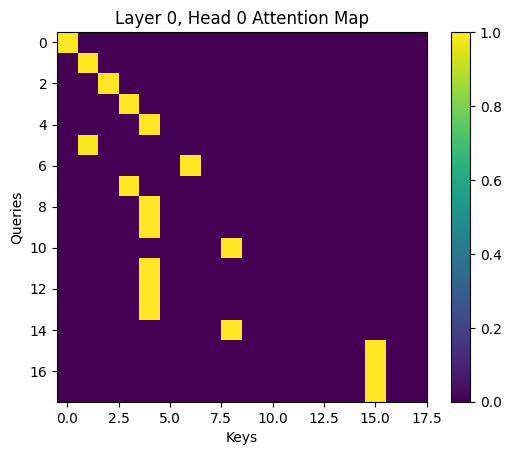

In [8]:
import matplotlib.pyplot as plt
import torch


# 文字単位トークン
sentence = "cat sat on the mat"
inputs = tokenizer.encode(sentence, return_tensors="pt").unsqueeze(0)

# モデルの出力 (Attentionを含む)
logits, loss, attentions = transformer.forward(inputs, targets=inputs)

def plot_attention(attn, layer_idx=0, head_idx=0):
    """
    特定の層とヘッドのAttention重みをヒートマップで可視化する
    """
    attn_weights = attn[layer_idx][0, head_idx].detach().cpu().numpy()  # Attention重みを取り出す
    plt.imshow(attn_weights, cmap="viridis", interpolation="nearest")
    plt.colorbar()
    plt.title(f"Layer {layer_idx}, Head {head_idx} Attention Map")
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()

# 1層目、1ヘッド目のAttentionを可視化
plot_attention(attentions, layer_idx=0, head_idx=0)


In [5]:
# 例えばLayer 0のすべてのHeadを表示する
layer_idx = 0
for head_idx in range(8):  # 8はHead数（適切な値に変更してください）
    plot_attention(attentions, layer_idx=layer_idx, head_idx=head_idx)


NameError: name 'plot_attention' is not defined

In [ ]:
#生成文法評価